In [1]:
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
import json
import pandas as pd

In [2]:
def get_y_val(x, xs, ys):
    for i in range(xs.shape[0]):
        if xs[i] > x:
            # This is upper bound, previous is lower bound
            if i == 0:
                end, start = xs[i], 0
                l = (x-start)/(end-start)
                return ys[i]#(l)*ys[i]
            end, start = xs[i], xs[i-1]
            l = (x-start)/(end-start)
            return (l)*ys[i] + (1-l)*ys[i-1]
    return ys[len(ys)-1]

def get_average_plot(data):
    end_time = 0
    for d in data:
        end_time = max(end_time, np.max(d[0]))
    xs = np.array(range(0, int(end_time)))
    yss = np.array([[get_y_val(x, d[0], d[1]) for x in xs] for d in data])
    ys_avg = np.median(yss, axis=0)#np.mean(yss, axis=0)
    ys_q75, ys_q25 = np.percentile(yss, [75 ,25], axis=0)
    #ys_std = np.std(yss, axis=0)
    return xs, ys_avg, ys_q75, ys_q25

def average_plot(data, color=(0.02745098, 0.50588235, 0.87058824), plot_std=True, label=None):
    xs, ys_avg, ys_q75, ys_q25 = get_average_plot(data)
    if plot_std:
        plt.fill_between(xs, ys_q25, ys_q75, color=(color[0], color[1], color[2], 0.25))
    plt.plot(xs, ys_avg, color=color, label=label)

def get_alternate_stats(data):
    xs, ys_avg, ys_q75, ys_q25 = get_average_plot(data)
    ys_std = ys_q75-ys_q25
    
    # Higher is better (0 (max accuracy 0 percent - 1 (max accuracy 100 percent))). The fraction of maxiumum possible value that was achived
    max_value = np.max(ys_avg) / 100
    # Higher is better (0 - 1). The fraction of possible area that the accuracy graph fills
    integral_fraction = np.sum(ys_avg) / (100*len(ys_avg))
    # Higher is better (0 (graph is reducing by infinity every timestep) - 1 (graph never goes down))
    stability = 0
    for i in range(1, len(ys_avg)):
        stability += min(0, ys_avg[i]-ys_avg[i-1])
    stability =  np.exp(stability)
    # Higher is better (0 (std is infinity every timestep) - 1 (std is 0 every timestep))
    consistency = np.exp(-np.sum(ys_std))
    return max_value, integral_fraction, stability, consistency
        

In [3]:
def read_database(path="./data"):
    db = []
    for filename in listdir(path):
        with open(path+"/"+filename, "r") as f:
            db.append(json.loads(f.read()))
    return db

def find_data(db, exid):
    data = []
    for d in db:
        if d['exid'] == exid:
            data.extend([np.array(x) for x in d['nodes_data']])
    if len(data) == 0:
        print("Cant find data for "+exid)
    return data

In [4]:
def setup_accuracy_graph(title, zoom=False, legend=True):
    plt.xticks([x for x in range(0, 21, 1)])
    if zoom:
        plt.ylim(80, 93)
        plt.yticks([x for x in range(80, 94, 1)])
    else:
        plt.ylim(0, 100)
        plt.yticks([x for x in range(0, 110, 10)])
    plt.xlim(0, 20)
    plt.xlabel("Epochs Trained")
    plt.ylabel("Average Accuracy")
    plt.grid()
    if legend:
        plt.legend()
    plt.title(title)

In [5]:
def colors(a, b, n):
    def lerp(a,b,x):
        return (1-x)*a + x*b
    x = 1/(n-1)
    cols = []
    for ni in range(n):
        xi = ni*x
        cols.append((lerp(a[0], b[0], xi), lerp(a[1], b[1], xi), lerp(a[2], b[2], xi)))
    return cols

In [6]:
db = read_database()
print("Experiment ids:", set([data["exid"] for data in db]))

Experiment ids: {'ex4B_(0.5)_(-0.5)_(5)', 'ex3_(9999)_0', 'ex4B_(0.7)_(-1.0)_(8)', 'ex4B_(1)_(0)_(0)', 'ex4B_(0)_(9999)_(5)', 'ex4B_(0.7)_(1.0)_(8)', 'ex3_(-0.5)_0', 'ex4B_(0.7)_(0)_(3)', 'ex4B_(1)_(-0.5)_(5)', 'ex3_(0)_3', 'ex4B_(1)_(-1.0)_(0)', 'ex3_(9999)_8', 'ex4B_(1)_(-0.5)_(0)', 'ex4B_(0.5)_(1.0)_(8)', 'ex4B_(0.9)_(1.0)_(3)', 'ex3_(0)_5', 'ex4_(0.5)_(9999)_(0)', 'ex1_asr_0.5', 'ex4B_(0.5)_(-1.0)_(8)', 'ex4B_(0)_(9999)_(3)', 'ex4B_(0.7)_(9999)_(3)', 'ex4B_(1)_(1.0)_(5)', 'ex3_(0)_0', 'ex4B_(0)_(0)_(0)', 'ex4B_(0.7)_(-1.0)_(5)', 'ex4B_(0)_(-0.5)_(8)', 'ex4B_(0.5)_(-0.5)_(0)', 'ex4B_(1)_(9999)_(8)', 'ex2_2', 'ex4B_(0.7)_(0)_(5)', 'ex4B_(0.5)_(0)_(3)', 'ex1_avg', 'ex4B_(0.5)_(9999)_(5)', 'ex1_asr_0.7', 'ex1_asr_0.3', 'ex4B_(0.5)_(9999)_(0)', 'ex4B_(1)_(1.0)_(0)', 'ex4B_(0.5)_(0)_(0)', 'ex2_0.5', 'ex4B_(0.9)_(0)_(5)', 'ex4B_(0.5)_(-1.0)_(5)', 'ex4B_(0)_(9999)_(0)', 'ex4_(0.5)_(9999)_(3)', 'ex4B_(0)_(0)_(8)', 'ex4B_(0)_(0)_(3)', 'ex4B_(0)_(0)_(5)', 'ex4B_(1)_(0)_(8)', 'ex4B_(0.5)_(-0.5

# Ex4

In [7]:
alphas = ["0.5", "0.7", "0.9", "1"]
betas = ["9999", "1.0", "0", "-0.5", "-1.0"]
gammas = ["0", "3", "5", "8"]
data_stats = []
for a in alphas:
    for b in betas:
        for g in gammas:
            max_val, integral, stability, consistency = get_alternate_stats(find_data(db, f"ex4B_({a})_({b})_({g})"))
            data_stats.append([a, b, g, max_val, integral, stability, consistency])

df = pd.DataFrame(data_stats, columns=["alpha", "beta", "gamma", "peak", "fill", "stability", "consistency"])
df

,alpha,beta,gamma,peak,fill,stability,consistency
0,0.5,9999,0,0.88740,0.788900,0.002699,5.542151e-28
1,0.5,9999,3,0.88950,0.777773,0.002277,3.965861e-32
2,0.5,9999,5,0.88765,0.781613,0.026121,2.521572e-28
3,0.5,9999,8,0.88765,0.783255,0.026516,8.229481e-32
4,0.5,1.0,0,0.88915,0.794767,0.000881,1.754550e-26
...,...,...,...,...,...,...,...
75,1,-0.5,8,0.85745,0.814077,0.585669,1.629349e-08
76,1,-1.0,0,0.90020,0.843090,0.506617,7.332361e-27
77,1,-1.0,3,0.89230,0.823583,0.016003,4.712120e-31
78,1,-1.0,5,0.87075,0.815290,0.337902,4.752597e-14


## Top 5 Plots

In [23]:
def top_plot(n, by, title, plot_std=False, show_fl=False, zoom=False):
    df_fill = df.sort_values(by=by.split("|"), ascending=False).reset_index(drop=True).head(n)
    cols = colors((1,0,0), (0,0,1), n)
    df_fill=df_fill.iloc[::-1]
    for i, row in df_fill.iterrows():
        label = "%s: α=%.1f  β=%.1f  γ=%.1f"%(i+1, float(row['alpha']),float(row['beta']),float(row['gamma']))
        label = label.replace("α=0.0", "α=AVG").replace("β=9999.0", "β=-∞ ")
        average_plot(find_data(db, f"ex4B_({row['alpha']})_({row['beta']})_({row['gamma']})"), label=label, color=cols[i], plot_std=plot_std)
    if show_fl:
        average_plot(find_data(db, "fed"), label="Federated", color=(0,0,0), plot_std=False)
    setup_accuracy_graph(title, zoom=zoom)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(reversed(handles), reversed(labels))
    plt.show()

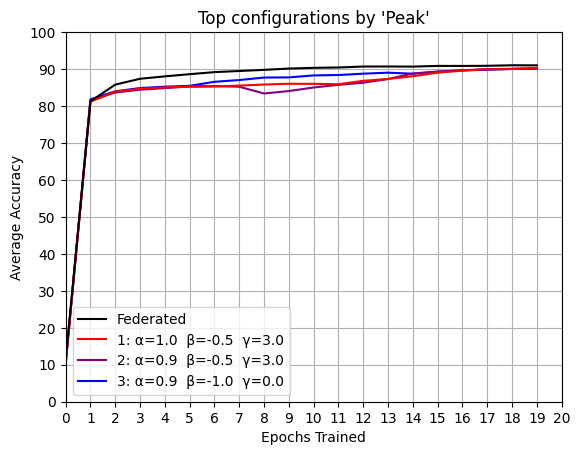

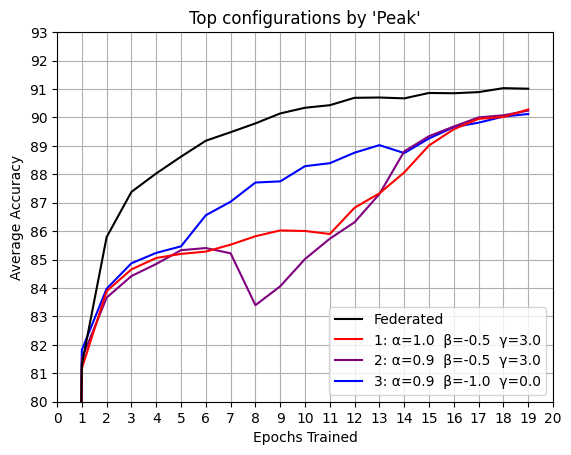

In [25]:
top_plot(3, "peak", "Top configurations by 'Peak'", show_fl=True)
top_plot(3, "peak", "Top configurations by 'Peak'", show_fl=True, zoom=True)

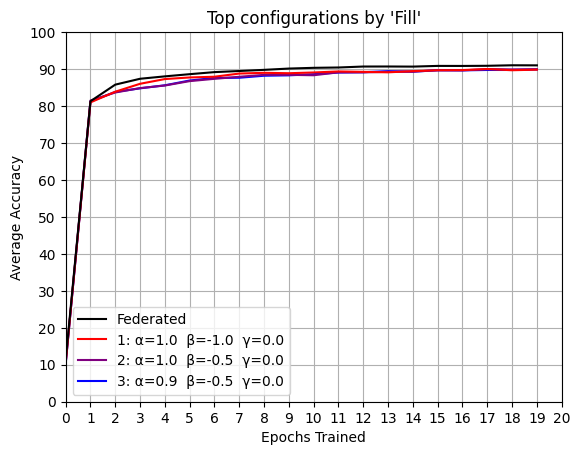

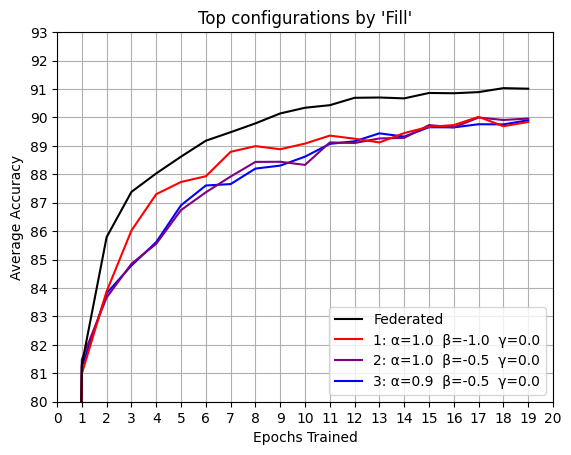

In [24]:
top_plot(3, "fill", "Top configurations by 'Fill'", show_fl=True)
top_plot(3, "fill", "Top configurations by 'Fill'", show_fl=True, zoom=True)

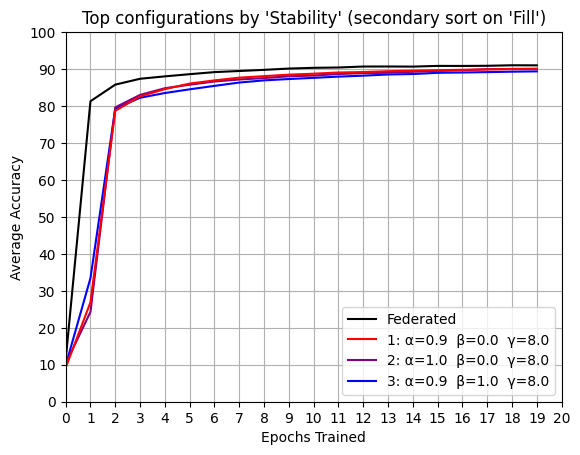

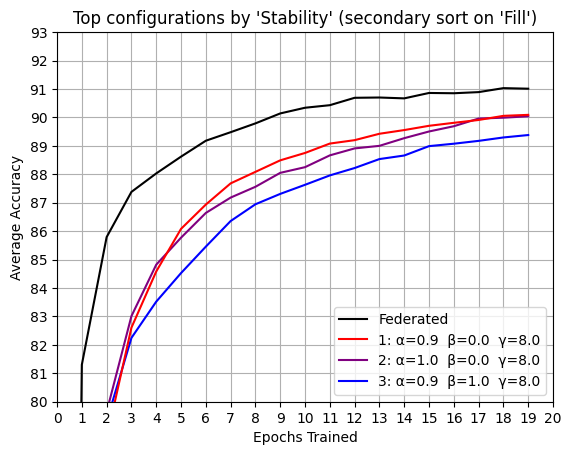

In [26]:
top_plot(3, "stability|fill", "Top configurations by 'Stability' (secondary sort on 'Fill')", show_fl=True)
top_plot(3, "stability|fill", "Top configurations by 'Stability' (secondary sort on 'Fill')", show_fl=True, zoom=True)

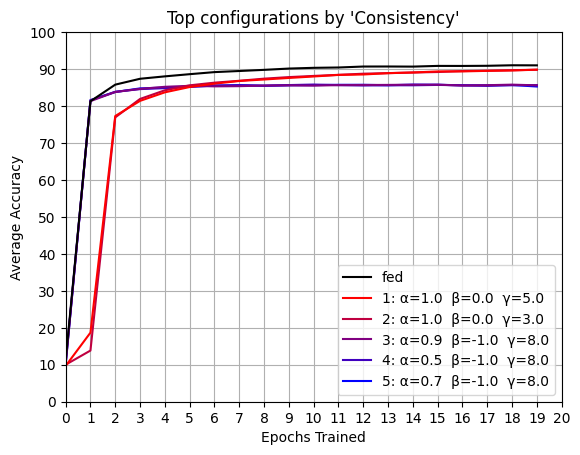

In [17]:
top_plot(5, "consistency", "Top configurations by 'Consistency'", show_fl=True)

## Comparison Of Top